# CNN Architectures
In this notebook we will explore standard CNN architectures using PyTorch and torchvision.

You can find more information on how to finetune pretrained models [here](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image
from torchsummary import summary

np.random.seed(42)

### CIFAR10 Dataset

In [2]:
# since we are going to use pretrained CNNs (on ImageNet), we need to normalize our data
# according to the mean and std with which these networks were trained, i.e. with the statistics of the ImageNet dataset
data_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=data_aug,
)

validation_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=data_aug,
)

print(f"Training size: {len(training_data)} \nValidation size: {len(validation_data)}")

Files already downloaded and verified
Files already downloaded and verified
Training size: 50000 
Validation size: 10000


In [3]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 64
num_workers = 2 # how many processes are used to load the data

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

Using cuda device


### Training loop

In [4]:
def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
	if is_train:
		assert optimizer is not None, "When training, please provide an optimizer."

	num_batches = len(dataloader)

	if is_train:
		model.train()	# put model in train mode

	else:
		model.eval()

	total_loss = 0.0
	preds = []
	labels = []

	with torch.set_grad_enabled(is_train):
		for batch, (X, y) in enumerate(tqdm(dataloader)):
			X, y = X.to(device), y.to(device)

			# Compute prediction error
			pred = model(X)
			loss = loss_fn(pred, y)

			if is_train:
				# Backpropagation
				optimizer.zero_grad()
				loss.backward()
				optimizer.step()

			# Save training metrics
			total_loss += loss.item()	# IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

			probs = F.softmax(pred, dim=1)
			final_pred = torch.argmax(probs, dim=1)
			preds.extend(final_pred.cpu().numpy())
			labels.extend(y.cpu().numpy())

	return total_loss / num_batches, accuracy_score(labels, preds)

In [5]:
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
	train_history = {'loss': [], 'accuracy': []}
	val_history = {'loss': [], 'accuracy': []}
	best_val_loss = np.inf
	print("Start training...")

	for t in range(num_epochs):
		print(f"\nEpoch {t+1}")
		train_loss, train_acc = epoch_iter(train_dataloader, model, loss_fn, optimizer)
		print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f}")
		val_loss, val_acc = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
		print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f}")

		# save model when val loss improves
		if val_loss < best_val_loss:
			best_val_loss = val_loss
			save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
			torch.save(save_dict, model_name + '_best_model.pth')

		# save latest model
		save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
		torch.save(save_dict, model_name + '_latest_model.pth')

		# save training history for plotting purposes
		train_history["loss"].append(train_loss)
		train_history["accuracy"].append(train_acc)

		val_history["loss"].append(val_loss)
		val_history["accuracy"].append(val_acc)

	print("Finished")
	
	return train_history, val_history

In [6]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

### 7x7 versus 3x3 Convolutions

Historically, the VGG was the first CNN architecture to introduce more layers (16-19 layers versus the 8 layers of AlexNet) and smaller convolutional kernel sizes (3x3).

This is mainly due to the fact that a stack of 3 3x3 convolutional layers (with stride 1) has the same effective receptive field as a single 7x7 layer. Why?

You can find out more about the effective receptive field of CNNs and explore some visualizations [here](https://blog.mlreview.com/a-guide-to-receptive-field-arithmetic-for-convolutional-neural-networks-e0f514068807).

Compare the number of parameters of a single convolutional layer with 7x7 kernel with a stack of 3 convolutional layers with 3x3 kernels.

In [7]:
m1 = nn.Sequential(nn.Conv2d(1, 1, kernel_size=(7, 7), padding=0)).to(device)

summary(m1, (1, 32, 32))

m2 = nn.Sequential(
    nn.Conv2d(1, 1, kernel_size=(3, 3), padding=0), 
    nn.Conv2d(1, 1, kernel_size=(3, 3), padding=0), 
    nn.Conv2d(1, 1, kernel_size=(3, 3), padding=0)
).to(device)

summary(m2, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 1, 26, 26]              50
Total params: 50
Trainable params: 50
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 1, 30, 30]              10
            Conv2d-2            [-1, 1, 28, 28]              10
            Conv2d-3            [-1, 1, 26, 26]              10
Total params: 30
Trainable params: 30
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB

What are the advantages of using a stack of 3 convolutional layers with 3x3 kernels instead of a single 7x7 layer?

# TODO:

### VGG model

Finetune a VGG-16 model.




In [8]:
# load model from torchvision (with pretrained=True)
vgg = models.vgg16(pretrained=True)
print(vgg)

# change the number of neurons in the last layer to the number of classes of the problem at hand (CIFAR10 dataset)
vgg.classifier[6] = nn.Linear(4096, 10)

vgg.to(device)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Inspect the model structure.

What does the AdaptiveAvgPool2d layer do?

What is the shape of the feature map before and after this layer?

Start training...

Epoch 1


100%|████████████████████████████████████████████████████████████████████████████████| 781/781 [00:51<00:00, 15.16it/s]


Train loss: 1.064 	 Train acc: 0.632


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:05<00:00, 26.49it/s]


Val loss: 0.732 	 Val acc: 0.746

Epoch 2


100%|████████████████████████████████████████████████████████████████████████████████| 781/781 [01:06<00:00, 11.66it/s]


Train loss: 0.687 	 Train acc: 0.763


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:06<00:00, 23.04it/s]


Val loss: 0.617 	 Val acc: 0.788

Epoch 3


100%|████████████████████████████████████████████████████████████████████████████████| 781/781 [02:13<00:00,  5.86it/s]


Train loss: 0.583 	 Train acc: 0.799


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:10<00:00, 15.23it/s]


Val loss: 0.572 	 Val acc: 0.805

Epoch 4


100%|████████████████████████████████████████████████████████████████████████████████| 781/781 [02:04<00:00,  6.28it/s]


Train loss: 0.516 	 Train acc: 0.823


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.99it/s]


Val loss: 0.529 	 Val acc: 0.817

Epoch 5


100%|████████████████████████████████████████████████████████████████████████████████| 781/781 [02:34<00:00,  5.06it/s]


Train loss: 0.462 	 Train acc: 0.841


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:11<00:00, 13.77it/s]


Val loss: 0.518 	 Val acc: 0.822

Epoch 6


100%|████████████████████████████████████████████████████████████████████████████████| 781/781 [01:53<00:00,  6.85it/s]


Train loss: 0.422 	 Train acc: 0.855


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:11<00:00, 13.87it/s]


Val loss: 0.491 	 Val acc: 0.831

Epoch 7


100%|████████████████████████████████████████████████████████████████████████████████| 781/781 [02:49<00:00,  4.62it/s]


Train loss: 0.388 	 Train acc: 0.866


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:12<00:00, 12.25it/s]


Val loss: 0.481 	 Val acc: 0.838

Epoch 8


100%|████████████████████████████████████████████████████████████████████████████████| 781/781 [02:50<00:00,  4.57it/s]


Train loss: 0.356 	 Train acc: 0.878


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.75it/s]


Val loss: 0.471 	 Val acc: 0.840

Epoch 9


100%|████████████████████████████████████████████████████████████████████████████████| 781/781 [02:50<00:00,  4.58it/s]


Train loss: 0.328 	 Train acc: 0.886


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.92it/s]


Val loss: 0.466 	 Val acc: 0.845

Epoch 10


100%|████████████████████████████████████████████████████████████████████████████████| 781/781 [03:16<00:00,  3.98it/s]


Train loss: 0.303 	 Train acc: 0.896


100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.97it/s]


Val loss: 0.467 	 Val acc: 0.844
Finished


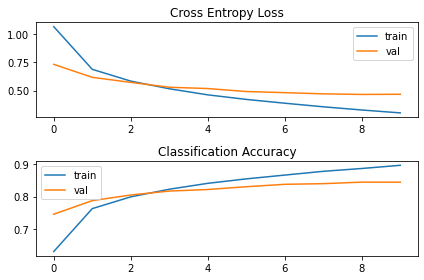

In [9]:
num_epochs = 10
model_name = 'vgg16'

loss_fn = nn.CrossEntropyLoss() # already includes the Softmax activation
optimizer_vgg = torch.optim.SGD(vgg.parameters(), lr=1e-3)

vgg_train_history, vgg_val_history = train(vgg, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer_vgg)

plotTrainingHistory(vgg_train_history, vgg_val_history)

### ResNet Model
Repeat the finetuning process with a ResNet-50 model.

In [ ]:
# TODO
# load model from torchvision (with pretrained=True)
resnet = 

# change the number of neurons in the last layer to the number of classes of the problem at hand (CIFAR10 dataset)

resnet.to(device)
print(resnet)

In [ ]:
num_epochs = 10
model_name = 'resnet50'

loss_fn = nn.CrossEntropyLoss() # already includes the Softmax activation
optimizer_resnet = torch.optim.SGD(resnet.parameters(), lr=1e-3)

resnet_train_history, resnet_val_history = train(resnet, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer_resnet)

plotTrainingHistory(resnet_train_history, resnet_val_history)

### Compare the VGG and ResNet models in terms of:


1.   number of parameters
2.   validation accuracy
3.   training time

What is the main difference introduced by the ResNet architecture?


In [ ]:
# TODO
# use torchsummary to compare the number of parameters of the VGG-16 and the ResNet-50